<a href="https://colab.research.google.com/github/C0FF33JH/C0FF33JH/blob/main/Lectures/12%20Single-Layer%20Perceptron/Keras%20Lab%3A%20Single-Layer%20Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single-Layer Perceptrons (SLPs)

## Table of Contents
1. [Introduction & Prerequisites](#1-introduction-prerequisites)  
2. [What is a Single-Layer Perceptron?](#2-what-is-a-single-layer-perceptron)  
3. [Sigmoid vs. Softmax — Key Differences](#3-sigmoid-vs-softmax)  
4. [Data Exploration & Insights](#4-data-exploration--insights)  
5. [Binary Classification: Breast Cancer (`sklearn.datasets`)](#5-binary-classification)  
   - [Handling Class Imbalance (Conceptual)](#51-handling-class-imbalance)  
6. [Hyperparameter Tuning (Learning Rates, Epochs)](#6-hyperparameter-tuning)  
7. [Multi-Class Classification: Fashion MNIST (`keras.datasets`)](#7-multi-class-classification)  
   - [Visualizing Weights in the SLP](#71-visualizing-weights)  
   - [More Detailed Error Analysis](#72-more-detailed-error-analysis)  
8. [Saving & Loading Models (End-to-End Workflow)](#8-saving--loading-models)  
9. [Lab Skeleton Notebook for Students](#9-lab-skeleton-notebook-for-students)  
10. [Wrap-up & Further Study](#10-wrap-up--further-study)

## 1. Introduction & Prerequisites

**Goal**:  
Build a **Single-Layer Perceptron (SLP)** for **binary classification** (Breast Cancer) and **multi-class classification** (Fashion MNIST). Along the way, we will:
- Explore data for better intuition.
- Implement **hyperparameter tuning** (learning rates, epochs).
- Visualize learned **weights** (for image data).
- Perform a more **detailed error analysis**.
- Discuss **handling class imbalance** conceptually.
- Demonstrate **saving & loading** models for an end-to-end ML workflow.

**Prerequisites**:
- Basic Python, NumPy, and Matplotlib.
- Familiarity with classification tasks (binary and multi-class).
- Libraries: `tensorflow`, `scikit-learn`, `matplotlib`, `numpy`.

```bash
pip install --upgrade pip
pip install tensorflow scikit-learn matplotlib numpy
```

## 2. What is a Single-Layer Perceptron?

A **Single-Layer Perceptron (SLP)** is one of the most fundamental neural network models. It consists of:
- **Input Layer**: Receives features $\{x_1, x_2, \ldots, x_n\}$.  
- **Output Layer**: Produces predictions (probabilities or logits).  
- **No Hidden Layers**: Exactly one set of weights from inputs to outputs.

**Typical SLP Setup**:
1. **Binary classification**:
   - **1 output neuron** (sigmoid activation).  
   - **Binary crossentropy** loss.
2. **Multi-class classification** (e.g., 10 classes):
   - **$k$ output neurons** (softmax activation).  
   - **(Sparse) categorical crossentropy** loss.

**Number of parameters** = $(\text{input_dim} \times \text{output_dim}) + \text{output_dim}$.  
- If input_dim = 784 (flattened 28×28) and output_dim = 10 => $(784 \times 10) + 10 = 7850$ parameters.

# 3. Sigmoid vs. Softmax — Key Differences

1. **Sigmoid** $\sigma(z)$  
   - **Formula**: $\sigma(z) = \frac{1}{1 + e^{-z}}$.  
   - **Output Range**: $(0, 1)$.  
   - Perfect for **binary** classification: 1 output neuron yields a probability for class = 1.

2. **Softmax**  
   - **Formula**: $\text{softmax}(z_j) = \frac{e^{z_j}}{\sum_{k} e^{z_k}}$.  
   - **Output Range**: Each class probability in $(0, 1)$, summing to 1.  
   - Perfect for **multi-class** classification: $\text{output_dim} = \text{#classes}$.

## 4. Data Exploration & Insights

Before diving into modeling, a brief **data exploration** helps us understand:
- Feature distributions.
- Potential class imbalances.
- Correlations or outliers.

In the **Breast Cancer** dataset, we might:
- Examine basic statistics of each feature (mean, std).
- Count how many “malignant” vs. “benign” samples to check if it’s balanced.

In **Fashion MNIST**, we might:
- Display a few sample images to see what the data looks like.

**Why do this?**  
1. **Better Intuition**: We know whether the dataset is balanced or skewed.  
2. **Feature Engineering**: EDA can suggest if scaling or transformations are needed.  
3. **Detecting Anomalies**: Sometimes there are outliers or missing values.

Below, we’ll incorporate minimal EDA to illustrate these points.

## 5. Binary Classification: Breast Cancer (`sklearn.datasets`)

### 5.1 Load & Quick Exploration

In [18]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
data_bc = load_breast_cancer()

X_bc = data_bc.data   # (569, 30) typically
y_bc = data_bc.target # (569,) => 0 or 1

print("Features shape:", X_bc.shape)
print("Labels shape:", y_bc.shape)
print("Feature names:", data_bc.feature_names)
print("Class distribution:\n",
      {name: count for name, count in zip(data_bc.target_names, np.bincount(y_bc))})

Features shape: (569, 30)
Labels shape: (569,)
Feature names: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Class distribution:
 {'malignant': 212, 'benign': 357}


**What the above code does**:
- Prints shapes, checks how many features (30).
- Prints how many malignant vs. benign cases.

#### Handling Class Imbalance (Conceptual)
If we find significant imbalance (say 90% benign, 10% malignant), we might:
- Use **metrics** like `precision`, `recall`, `F1-score` instead of just accuracy.  
- Adjust **class_weights** in `model.fit()`.  
- Perform **oversampling** or **undersampling**.  

Breast Cancer is not extremely imbalanced, but it’s still important to check.

### 5.2 Split, Scale, and Build SLP

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_bc, X_test_bc, y_train_bc, y_test_bc = train_test_split(
    X_bc, y_bc,
    test_size=0.2,
    random_state=42
)

scaler_bc = StandardScaler()
X_train_bc_scaled = scaler_bc.fit_transform(X_train_bc)
X_test_bc_scaled  = scaler_bc.transform(X_test_bc)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# RERUN THE ENTIRE SECTION TO RETRAIN
model_bc = keras.Sequential([
    layers.Dense(1, activation='sigmoid', input_shape=(X_train_bc.shape[1],))
])
model_bc.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_bc.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31 (124.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

### 5.3 Train & Evaluate

In [20]:
history_bc = model_bc.fit(
    X_train_bc_scaled, y_train_bc,
    validation_split=0.2,
    epochs=10,
    # 32 data points per iteration
    batch_size=32,
    verbose=1
)

test_loss_bc, test_acc_bc = model_bc.evaluate(X_test_bc_scaled, y_test_bc)
print(f"BC Test Loss: {test_loss_bc:.4f}")
print(f"BC Test Accuracy: {test_acc_bc:.4f}")

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.4222 - loss: 0.9571 - val_accuracy: 0.5165 - val_loss: 0.8867
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5044 - loss: 0.8212 - val_accuracy: 0.5495 - val_loss: 0.8109
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5422 - loss: 0.7729 - val_accuracy: 0.6044 - val_loss: 0.7424
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5556 - loss: 0.7268 - val_accuracy: 0.6374 - val_loss: 0.6809
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6403 - loss: 0.6786 - val_accuracy: 0.6484 - val_loss: 0.6313
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6923 - loss: 0.5742 - val_accuracy: 0.6703 - val_loss: 0.5870
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7177 - loss: 0.5913 - val_accuracy: 0.6923 - val_loss: 0.5491
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7530 - loss: 0.5153 - val_accuracy: 0.6923 - val_loss

#### Plot Learning Curves

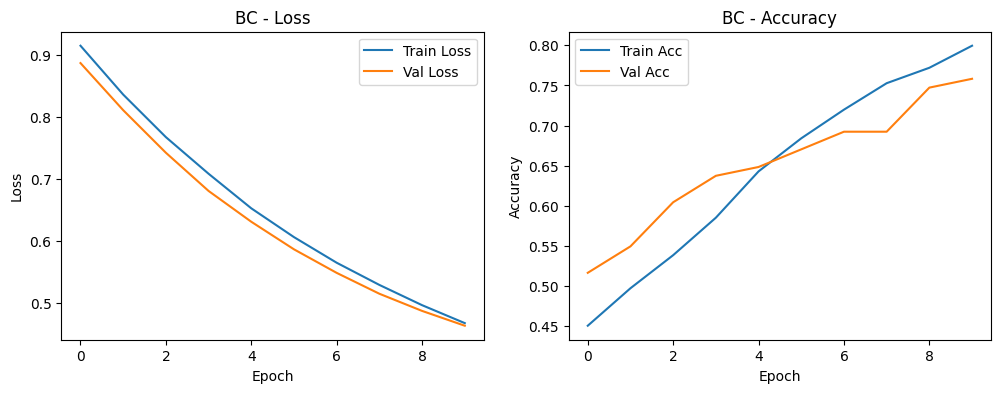

In [21]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_bc.history['loss'], label='Train Loss')
plt.plot(history_bc.history['val_loss'], label='Val Loss')
plt.title("BC - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_bc.history['accuracy'], label='Train Acc')
plt.plot(history_bc.history['val_accuracy'], label='Val Acc')
plt.title("BC - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

#### Confusion Matrix & Classification Report

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred_bc_probs = model_bc.predict(X_test_bc_scaled)
y_pred_bc = (y_pred_bc_probs > 0.5).astype(int).ravel()

cm_bc = confusion_matrix(y_test_bc, y_pred_bc)
print("Breast Cancer Confusion Matrix:\n", cm_bc)

print("Breast Cancer Classification Report:\n",
      classification_report(y_test_bc, y_pred_bc))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Breast Cancer Confusion Matrix:
 [[35  8]
 [15 56]]
Breast Cancer Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.81      0.75        43
           1       0.88      0.79      0.83        71

    accuracy                           0.80       114
   macro avg       0.79      0.80      0.79       114
weighted avg       0.81      0.80      0.80       114



### 5.1 Handling Class Imbalance (Conceptual)

In [23]:
# If, for instance, we discovered a heavy imbalance in classes,
# we could try:

# model_bc.fit(
#    X_train_bc_scaled, y_train_bc,
#    class_weight={0: 2.0, 1: 1.0},  # Example weighting
#    ...
# )

> **Why?**  
> Giving **higher weight** to the minority class can help the network pay more attention to it, improving metrics like recall for that class.

Since the Breast Cancer dataset is not severely imbalanced, we might not need this, but it’s **important** students understand how to handle imbalance if it arises.

## 6. Hyperparameter Tuning (Learning Rates, Epochs)

**Hyperparameters** such as:
- **Learning rate** (`optimizer` parameters, e.g., `Adam(lr=0.001)`).
- **Number of epochs**.
- **Batch size**.

significantly influence model performance.

### 6.1 Example: Adjusting Learning Rate & Epochs

In [24]:
from tensorflow.keras.optimizers import Adam

# Let's try a smaller learning rate and more epochs
model_bc_tuned = keras.Sequential([
    layers.Dense(1, activation='sigmoid', input_shape=(X_train_bc.shape[1],))
])
# e.g. learning_rate=0.0005 instead of the default 0.001
model_bc_tuned.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_bc_tuned = model_bc_tuned.fit(
    X_train_bc_scaled, y_train_bc,
    validation_split=0.2,
    epochs=50,  # increased
    batch_size=32,
    verbose=1
)

test_loss_tuned, test_acc_tuned = model_bc_tuned.evaluate(X_test_bc_scaled, y_test_bc)
print(f"Tuned BC Loss: {test_loss_tuned:.4f}")
print(f"Tuned BC Accuracy: {test_acc_tuned:.4f}")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.1895 - loss: 1.4419 - val_accuracy: 0.2308 - val_loss: 1.4722
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1792 - loss: 1.4063 - val_accuracy: 0.2308 - val_loss: 1.4083
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2104 - loss: 1.3055 - val_accuracy: 0.2308 - val_loss: 1.3447
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2074 - loss: 1.2693 - val_accuracy: 0.2308 - val_loss: 1.2837
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2507 - loss: 1.1749 - val_accuracy: 0.2418 - val_loss: 1.2252
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2541 - loss: 1.1579 - val_accuracy: 0.2527 - val_loss: 1.1680
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2917 - loss: 1.1114 - val_accuracy: 0.2637 - val_loss: 1.1138
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2761 - loss: 1.0639 - val_accuracy: 0.2967 - val_loss: 1.0617
Ep

**Why try smaller LR & more epochs?**  
- A smaller learning rate helps the model converge more *gradually*, potentially avoiding overshoot.  
- More epochs allow the model to refine its weights further.

If the dataset is small and you see overfitting, you may not need too many epochs. Tuning these hyperparameters is **iterative** and often dataset-specific.

## 7. Multi-Class Classification: Fashion MNIST (`keras.datasets`)

**Objective**:
Classify 28×28 grayscale images into 10 classes of clothing items. A Single-Layer Perceptron will act as a simple baseline.

### 7.1 Load, Inspect & Explore

In [25]:
from tensorflow.keras.datasets import fashion_mnist

(X_train_fm, y_train_fm), (X_test_fm, y_test_fm) = fashion_mnist.load_data()

print("FM Train shape:", X_train_fm.shape)   # (60000, 28, 28)
print("FM Train labels:", y_train_fm.shape)  # (60000,)
print("Unique classes:", np.unique(y_train_fm))

FM Train shape: (60000, 28, 28)
FM Train labels: (60000,)
Unique classes: [0 1 2 3 4 5 6 7 8 9]


**Data Exploration**:
- Optional: Display some sample images.

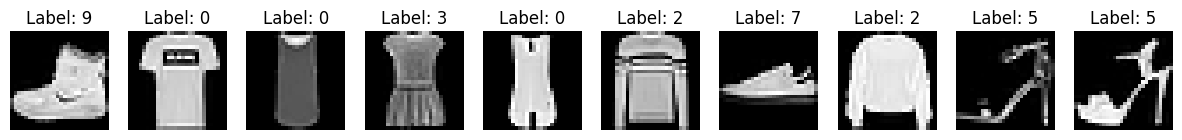

In [26]:
import matplotlib.pyplot as plt

# Display the first 5 images
plt.figure(figsize=(15,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(X_train_fm[i], cmap='gray')
    plt.title(f"Label: {y_train_fm[i]}")
    plt.axis('off')
plt.show()

### 7.2 Preprocess & Build SLP

1. **Rescale** from \([0..255]\) to \([0..1]\).  
2. **Flatten** images to 784-dim vectors.  
3. **Output layer** = 10 neurons (softmax).


In [27]:
X_train_fm = X_train_fm / 255.0
X_test_fm  = X_test_fm / 255.0

X_train_fm_flat = X_train_fm.reshape(-1, 28*28)
X_test_fm_flat  = X_test_fm.reshape(-1, 28*28)

model_fm = keras.Sequential([
    layers.Dense(10, activation='softmax', input_shape=(784,))
])
model_fm.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_fm.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 10)                  │           7,850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

### 7.3 Train & Evaluate


In [28]:
history_fm = model_fm.fit(
    X_train_fm_flat, y_train_fm,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

test_loss_fm, test_acc_fm = model_fm.evaluate(X_test_fm_flat, y_test_fm)
print(f"Fashion MNIST - Test Loss: {test_loss_fm:.4f}")
print(f"Fashion MNIST - Test Accuracy: {test_acc_fm:.4f}")

Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7263 - loss: 0.8149 - val_accuracy: 0.8253 - val_loss: 0.5035
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8340 - loss: 0.4877 - val_accuracy: 0.8454 - val_loss: 0.4559
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8490 - loss: 0.4446 - val_accuracy: 0.8423 - val_loss: 0.4576
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8544 - loss: 0.4275 - val_accuracy: 0.8481 - val_loss: 0.4376
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8543 - loss: 0.4199 - val_accuracy: 0.8492 - val_loss: 0.4398
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8545 - loss: 0.4158 - val_accuracy: 0.8458 - val_loss: 0.4346
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8582 - loss: 0.4032 - val_accuracy: 0.8547 - val_loss: 0.4254
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8626 - loss: 0.4009 - 

#### Plot Curves

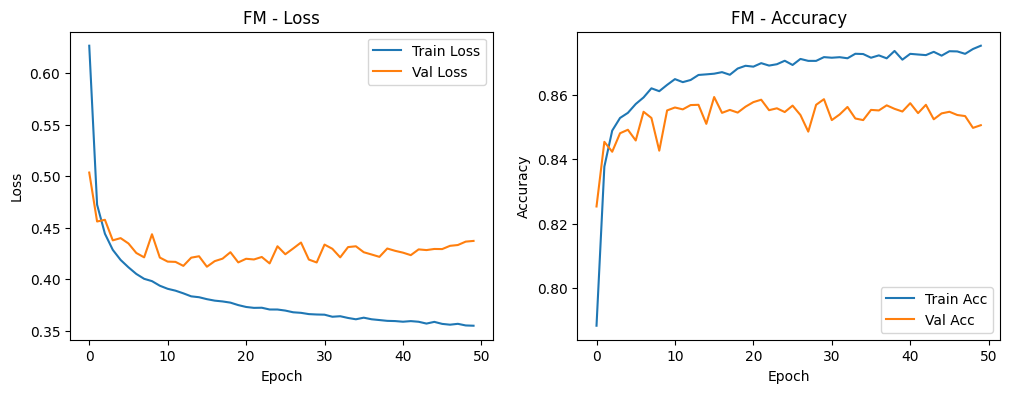

In [29]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_fm.history['loss'], label='Train Loss')
plt.plot(history_fm.history['val_loss'], label='Val Loss')
plt.title("FM - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_fm.history['accuracy'], label='Train Acc')
plt.plot(history_fm.history['val_accuracy'], label='Val Acc')
plt.title("FM - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

#### Confusion Matrix & Classification Report

In [30]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred_fm_probs = model_fm.predict(X_test_fm_flat)
y_pred_fm = np.argmax(y_pred_fm_probs, axis=1)

cm_fm = confusion_matrix(y_test_fm, y_pred_fm)
print("Fashion MNIST Confusion Matrix:\n", cm_fm)
print("Fashion MNIST Classification Report:\n",
      classification_report(y_test_fm, y_pred_fm))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Fashion MNIST Confusion Matrix:
 [[739   3  20  80   6   1 142   0   9   0]
 [  1 956   5  29   4   0   3   0   2   0]
 [ 17   3 788  18  95   0  73   0   6   0]
 [ 16  12  20 890  26   0  30   0   6   0]
 [  0   1 151  49 729   0  67   0   3   0]
 [  0   0   0   1   0 919   0  42   4  34]
 [ 87   2 151  69 101   0 569   0  21   0]
 [  0   0   0   0   0  36   0 905   0  59]
 [  4   1  11  14   3   6  22   5 933   1]
 [  0   1   0   0   0   7   1  25   0 966]]
Fashion MNIST Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.74      0.79      1000
           1       0.98      0.96      0.97      1000
           2       0.69      0.79      0.73      1000
           3       0.77      0.89      0.83      1000
           4       0.76      0.73      0.74      1000
           5       0.95      0.92      0.93      1000
           6       0.63      0.57      0.60      1000
           7       0.93 

### 7.1 Visualizing Weights in the SLP

A single-layer perceptron with 10 outputs has a **weight vector** of length 784 for each class. We can reshape each 784-length weight vector into a 28×28 grid to see what “pattern” the model has learned for each class.

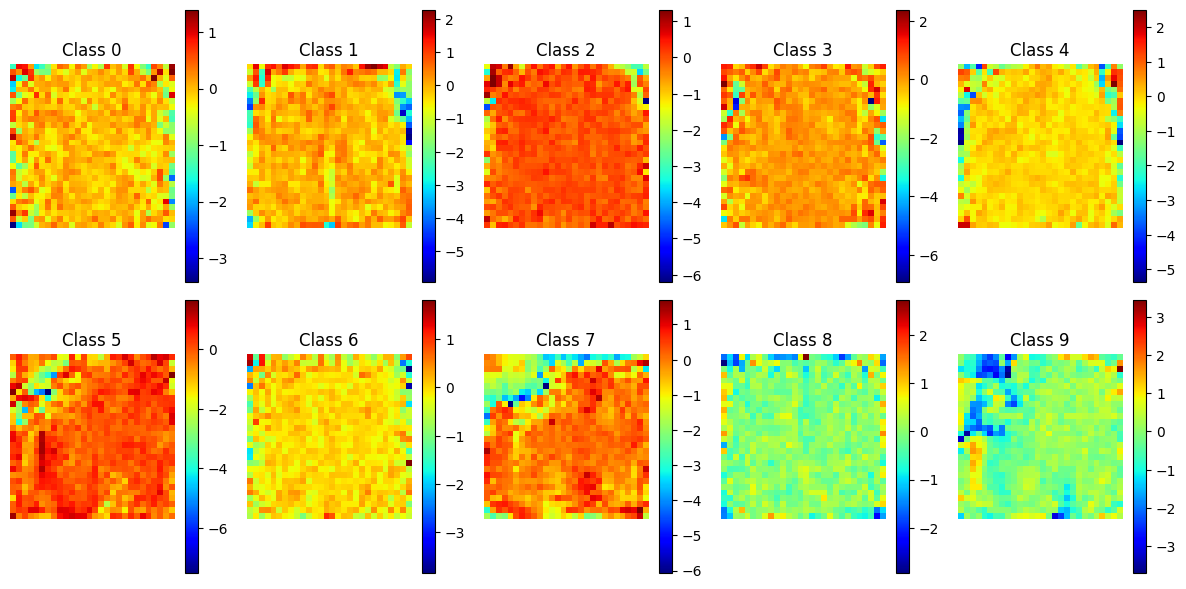

In [31]:
weights_fm = model_fm.get_weights()[0]  # shape: (784, 10)
biases_fm = model_fm.get_weights()[1]   # shape: (10,)

plt.figure(figsize=(12,6))
for i in range(10):
    # Extract the weight vector for class i
    w_i = weights_fm[:, i]
    # Reshape to 28x28
    w_i_2d = w_i.reshape(28, 28)
    plt.subplot(2,5,i+1)
    plt.imshow(w_i_2d, cmap='jet')
    plt.title(f"Class {i}")
    plt.colorbar()
    plt.axis('off')
plt.tight_layout()
plt.show()

**Why do this?**  
- It’s fascinating to see if the model highlights certain regions of the image for a given class, even though it’s just a simple linear map.

### 7.2 More Detailed Error Analysis

We can see which items get misclassified frequently. For instance:

Number of misclassified samples: 1606


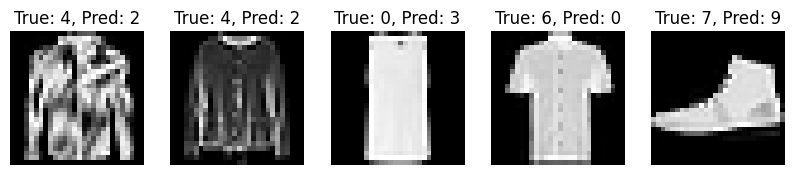

In [32]:
incorrect_idx = np.where(y_pred_fm != y_test_fm)[0]
print(f"Number of misclassified samples: {len(incorrect_idx)}")

# Show some misclassified images
plt.figure(figsize=(10,4))
for i, idx in enumerate(incorrect_idx[:5]):
    plt.subplot(1,5,i+1)
    plt.imshow(X_test_fm[idx], cmap='gray')
    plt.title(f"True: {y_test_fm[idx]}, Pred: {y_pred_fm[idx]}")
    plt.axis('off')
plt.show()

**Why do this?**  
- Helps us understand which classes are confusing. For instance, the model might confuse “shirt” vs. “t-shirt” or “pullover” if they visually appear similar.

## 8. Saving & Loading Models (End-to-End Workflow)

After training, it’s crucial to **save** the model so you don’t have to retrain every time, or so you can **deploy** or **share** it.

In [33]:
# Save the Fashion MNIST model
model_fm.save("slp_fashion_mnist.h5")

# Later or in another script, load it:
loaded_model_fm = tf.keras.models.load_model("slp_fashion_mnist.h5")

You can then evaluate `loaded_model_fm` on test data again to confirm it’s the same:

In [34]:
loaded_loss, loaded_acc = loaded_model_fm.evaluate(X_test_fm_flat, y_test_fm)
print(f"Loaded Model - Test Loss: {loaded_loss:.4f}, Test Acc: {loaded_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8414 - loss: 0.4577
Loaded Model - Test Loss: 0.4702, Test Acc: 0.8394


**Why do this?**  
- **Practical**: In real projects, you rarely keep your model in memory. You train it once and save it for inference later or for future fine-tuning.  
- **Collaboration**: Team members can use your saved model for inference or production deployment.

## 9. Wrap-up & Further Study

### Summary
- **Data Exploration** helps detect issues (imbalance, anomalies) and informs choices (scaling, weighting).
- **SLPs** are easy to understand but limited for complex tasks.
- **Hyperparameter tuning** (learning rates, epochs) can significantly affect performance.
- **Visualizing weights** for image tasks can provide insights.
- **Detailed error analysis** (misclassified examples) reveals model weaknesses.
- **Model saving/loading** is crucial for real-world workflow.

### Next Steps
1. **Add hidden layers** to see how a **multilayer perceptron (MLP)** outperforms an SLP on Fashion MNIST.  
2. **Use callbacks** like `EarlyStopping` or `ReduceLROnPlateau` for more advanced training control.  
3. **Experiment with other optimizers** (e.g., `SGD`, `RMSprop`), batch sizes, or epoch counts.  
4. **Try new datasets** (MNIST, CIFAR-10, or custom data) to expand your skill set.  
5. **Investigate more advanced error analysis** (e.g., Grad-CAM for CNN-based tasks, or SHAP for interpretability).